In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scanpy as sc

(data-camp) C:\Users\maixe\OneDrive\Documents\M2 DS\DATACAMP\data-camp-single-cell-scmark-classification-october-2023-gabriel_traore> cd C:\Users\maixe\OneDrive\Documents\M2 DS\DATACAMP\data-camp-single-cell-scmark-classification-october-2023-gabriel_traore\submissions\SELEC_2   
## Pour lancer le test

In [25]:
from problem import get_train_data, get_test_data
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

lab_df = pd.DataFrame({'label': y_train})
lab_df.value_counts(normalize=True)

lab_df.describe(), X_test.shape, y_test.shape

(               label
 count           1000
 unique             4
 top     T_cells_CD8+
 freq             342,
 (500, 13551),
 (500,))

In [26]:
def preprocess_X(X):
    X = X.toarray()
    X = sc.pp.log1p(X) # AJOUT
    #X = np.log1p(X)
    return X / X.sum(axis=1)[:, np.newaxis]

X_train_norm = preprocess_X(X_train)
X_test_norm = preprocess_X(X_test)
# sanity check
np.allclose(X_train_norm.sum(axis=1), np.ones(X_train_norm.shape[0])), X_train_norm

(True,
 array([[0.00016123, 0.        , 0.        , ..., 0.00032246, 0.00025555,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.0003768 , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.00050598, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]], dtype=float32))

In [27]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: scikit-learn in c:\users\astri\anaconda3\envs\data-camp\lib\site-packages (1.3.2)



In [28]:
##The score function
from sklearn.metrics import balanced_accuracy_score
from problem import BalancedAccuracy
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier #0.60
from sklearn.svm import SVC # 0.75
from sklearn.neighbors import KNeighborsClassifier #0.69
from sklearn.tree import DecisionTreeClassifier # 0.63
from sklearn.ensemble import BaggingClassifier # 0.66
from sklearn.tree import ExtraTreeClassifier # 0.578
from sklearn.neural_network import MLPClassifier #0.76
from sklearn.ensemble import GradientBoostingClassifier #0.684

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD


In [29]:
## SVC PCA RF MLP

Stacking model balanced accuracy on test set: 0.768


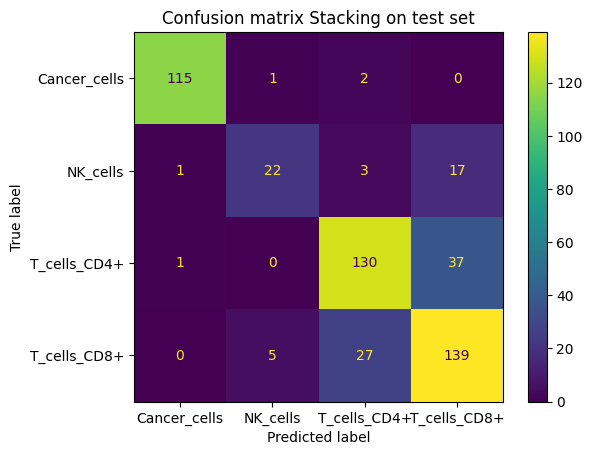

In [30]:
# Define base models
base_models = [
    #('pca_svc', make_pipeline(StandardScaler(with_mean=True, with_std=True), PCA(n_components=70), SVC(kernel='linear', C=1.0))),
    ('rf', make_pipeline(StandardScaler(with_mean=True, with_std=True), PCA(n_components=85), RandomForestClassifier(n_estimators=50,max_features=3))),
    #('knn', make_pipeline(TruncatedSVD(n_components=20),KNeighborsClassifier(n_neighbors=5))),
    ('mlp', make_pipeline(StandardScaler(with_mean=True, with_std=True), TruncatedSVD(n_components=120), MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=1000))),
]

# Define the meta-model
meta_model = MLPClassifier(hidden_layer_sizes=(64, 64), activation='relu', solver='adam', max_iter=1000)

# Create the stacking classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Define the overall pipeline
pipeline = Pipeline([
    ('preprocess', StandardScaler(with_mean=True, with_std=True)),  # You can add any preprocessing steps here
    ('stacking', stacking_clf)
])

'''
# StandardScaler with_mean=False for sparse matrix
scaler = StandardScaler(with_mean=False)

# Fit and transform the sparse matrix
X = X_train.toarray()
X = sc.pp.log1p(X)
X_scaled = scaler.fit_transform(X_train)
X_scaled_test = scaler.fit_transform(X_test)
'''

# Train the pipeline
pipeline.fit(X_train_norm, y_train)

# Predict on the test set
y_te_pred_stacking = pipeline.predict(X_test_norm)

# Compute balanced accuracy and confusion matrix for the stacking model
print(f"Stacking model balanced accuracy on test set: {balanced_accuracy_score(y_test, y_te_pred_stacking):.3f}")
cm_stacking = confusion_matrix(y_test, y_te_pred_stacking)
disp_stacking = ConfusionMatrixDisplay(confusion_matrix=cm_stacking, display_labels=np.unique(y_test))
disp_stacking.plot()
plt.title("Confusion matrix Stacking on test set")
plt.show()

In [31]:
## from sklearn.feature_selection import VarianceThreshold

def select_features_by_variance(X, threshold=0.1):
    """
    Sélectionne les caractéristiques dont la variance est supérieure au seuil spécifié.
    :param X: données d'entrée (caractéristiques).
    :param threshold: seuil de variance pour la sélection des caractéristiques.
    :return: X filtré avec seulement les caractéristiques sélectionnées.
    """
    selector = VarianceThreshold(threshold)
    X_selected = selector.fit_transform(X)
    return X_selected, selector.get_support(indices=True)


In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

# Define the hyperparameter grid
param_grid = {
    'pca_svc__truncatedsvd__n_components': [10, 20, 30],
    'pca_svc__svc__C': [0.1, 1.0, 10.0],
    'rf__truncatedsvd__n_components': [50, 75, 100],
    'rf__randomforestclassifier__n_estimators': [50, 100, 200],
    'rf__randomforestclassifier__max_features': [2, 3, 4],
    'meta_model__hidden_layer_sizes': [(100, 50), (50, 25), (150, 100)],
    'meta_model__activation': ['relu', 'tanh'],
    'meta_model__solver': ['adam', 'lbfgs'],
    'meta_model__max_iter': [1000, 1500, 2000]
}

utiliser la selection des variable // construction des features, prédire en biclasse

In [33]:
##encoder les variables catégoricielles

from sklearn.preprocessing import LabelEncoder

# Créer une instance de LabelEncoder
label_encoder = LabelEncoder()

# Appliquer l'encodage aux données
y_train_encoded = label_encoder.fit_transform(y_train)

# Afficher les premières lignes de la série encodée
print(y_train_encoded)


[2 2 2 2 3 2 0 0 1 3 2 2 0 0 0 2 0 2 0 0 2 1 3 0 3 2 2 0 0 3 2 2 3 3 2 1 2
 2 3 1 3 3 2 3 3 3 2 2 3 2 3 3 3 0 2 2 2 2 3 0 2 3 3 0 3 0 0 3 3 0 3 0 3 3
 3 2 0 2 2 3 3 0 2 3 0 1 2 0 3 3 2 2 3 3 0 3 0 1 0 1 1 3 3 0 2 2 0 2 3 0 3
 3 2 2 2 0 2 1 1 3 1 2 3 3 2 2 0 2 3 3 0 2 1 3 3 0 0 2 2 3 3 3 2 2 3 2 2 1
 2 3 0 3 0 0 0 3 3 2 3 2 0 3 3 3 2 2 3 0 0 1 0 3 0 3 2 2 0 1 0 3 2 3 2 3 1
 1 3 3 0 2 2 0 3 0 0 0 0 2 3 0 2 3 0 3 2 0 1 3 0 3 3 3 3 0 0 2 2 0 0 0 0 2
 2 1 3 3 1 3 3 0 0 2 0 0 1 3 0 0 3 2 3 3 3 3 2 1 3 2 2 3 2 2 0 2 3 0 3 3 1
 0 3 3 0 2 3 0 3 3 2 3 3 0 3 2 2 3 0 0 2 0 2 3 2 0 2 2 0 0 3 0 0 3 0 2 2 3
 3 2 1 3 3 3 2 0 0 2 2 3 0 3 2 3 3 1 3 3 2 2 3 2 0 0 3 3 2 0 3 3 3 0 3 3 1
 1 2 3 3 3 1 1 3 3 3 2 3 0 2 0 3 2 2 2 2 2 3 2 2 2 3 2 2 1 3 0 0 2 3 2 3 0
 3 2 2 2 3 3 0 3 3 2 0 3 3 3 2 3 2 2 3 2 0 2 3 2 1 3 3 2 2 2 0 2 3 3 3 0 2
 0 2 3 3 0 0 3 3 2 2 0 2 3 0 2 2 2 1 3 0 2 1 0 0 2 2 0 3 2 2 0 2 0 3 0 3 3
 3 0 2 1 2 0 2 3 2 0 0 3 0 2 2 0 3 2 3 3 2 2 1 1 2 3 3 3 2 0 0 0 3 2 2 3 2
 3 3 2 2 2 2 2 2 0 0 0 2 

In [34]:
def encode_categorical_variables(data):
    # Créer une instance de LabelEncoder
    label_encoder = LabelEncoder()

    # Appliquer l'encodage aux données
    encoded_data = label_encoder.fit_transform(data)

    return encoded_data

# Exemple d'utilisation sur votre ensemble de données y_train
y_train_encoded = encode_categorical_variables(y_train)

# Afficher les premières lignes de la série encodée
print(y_train_encoded)

[2 2 2 2 3 2 0 0 1 3 2 2 0 0 0 2 0 2 0 0 2 1 3 0 3 2 2 0 0 3 2 2 3 3 2 1 2
 2 3 1 3 3 2 3 3 3 2 2 3 2 3 3 3 0 2 2 2 2 3 0 2 3 3 0 3 0 0 3 3 0 3 0 3 3
 3 2 0 2 2 3 3 0 2 3 0 1 2 0 3 3 2 2 3 3 0 3 0 1 0 1 1 3 3 0 2 2 0 2 3 0 3
 3 2 2 2 0 2 1 1 3 1 2 3 3 2 2 0 2 3 3 0 2 1 3 3 0 0 2 2 3 3 3 2 2 3 2 2 1
 2 3 0 3 0 0 0 3 3 2 3 2 0 3 3 3 2 2 3 0 0 1 0 3 0 3 2 2 0 1 0 3 2 3 2 3 1
 1 3 3 0 2 2 0 3 0 0 0 0 2 3 0 2 3 0 3 2 0 1 3 0 3 3 3 3 0 0 2 2 0 0 0 0 2
 2 1 3 3 1 3 3 0 0 2 0 0 1 3 0 0 3 2 3 3 3 3 2 1 3 2 2 3 2 2 0 2 3 0 3 3 1
 0 3 3 0 2 3 0 3 3 2 3 3 0 3 2 2 3 0 0 2 0 2 3 2 0 2 2 0 0 3 0 0 3 0 2 2 3
 3 2 1 3 3 3 2 0 0 2 2 3 0 3 2 3 3 1 3 3 2 2 3 2 0 0 3 3 2 0 3 3 3 0 3 3 1
 1 2 3 3 3 1 1 3 3 3 2 3 0 2 0 3 2 2 2 2 2 3 2 2 2 3 2 2 1 3 0 0 2 3 2 3 0
 3 2 2 2 3 3 0 3 3 2 0 3 3 3 2 3 2 2 3 2 0 2 3 2 1 3 3 2 2 2 0 2 3 3 3 0 2
 0 2 3 3 0 0 3 3 2 2 0 2 3 0 2 2 2 1 3 0 2 1 0 0 2 2 0 3 2 2 0 2 0 3 0 3 3
 3 0 2 1 2 0 2 3 2 0 0 3 0 2 2 0 3 2 3 3 2 2 1 1 2 3 3 3 2 0 0 0 3 2 2 3 2
 3 3 2 2 2 2 2 2 0 0 0 2 

In [35]:
# Importation des bibliothèques nécessaires
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import numpy as np

# 1. LASSO
lasso_model = Lasso(alpha=0.05)  # alpha contrôle la force de la pénalité
lasso_model.fit(X_train, y_train_encoded) ## le lasso prend en compte les valeurs numérique, et c'est la raison poiur laquelle on a encodé les données y_train
lasso_selected_features = np.where(lasso_model.coef_ != 0)[0]
#print("Variables sélectionnées par LASSO:", lasso_selected_features)

# 2. Sélection des variables
X_train_selected=X_train[:, lasso_selected_features]
X_test_selected=X_test[:, lasso_selected_features]

# Afficher 
print(X_train_selected)
X_train.shape, X_train_selected.shape, y_train.shape, y_train_encoded.shape

  (0, 0)	167.0
  (0, 2)	9.0
  (0, 7)	1.0
  (0, 8)	9.0
  (0, 10)	36.0
  (0, 11)	152.0
  (0, 12)	17.0
  (0, 13)	8.0
  (0, 14)	12.0
  (0, 16)	2.0
  (0, 17)	12.0
  (0, 18)	1.0
  (0, 19)	8.0
  (0, 20)	33.0
  (0, 21)	17.0
  (0, 22)	17.0
  (0, 25)	17.0
  (0, 27)	2.0
  (0, 28)	2.0
  (0, 30)	2.0
  (0, 71)	6.0
  (0, 31)	4.0
  (0, 32)	10.0
  (0, 33)	128.0
  (0, 34)	9.0
  :	:
  (999, 72)	3.0
  (999, 67)	3.0
  (999, 53)	1.0
  (999, 52)	8.0
  (999, 45)	1.0
  (999, 42)	2.0
  (999, 41)	4.0
  (999, 40)	2.0
  (999, 36)	1.0
  (999, 35)	1.0
  (999, 34)	1.0
  (999, 32)	3.0
  (999, 30)	8.0
  (999, 28)	1.0
  (999, 22)	4.0
  (999, 20)	1.0
  (999, 19)	2.0
  (999, 17)	1.0
  (999, 16)	2.0
  (999, 15)	2.0
  (999, 13)	6.0
  (999, 11)	13.0
  (999, 8)	1.0
  (999, 1)	1.0
  (999, 0)	6.0


C:\Users\astri\anaconda3\envs\data-camp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56.926456451416016, tolerance: 0.13279110193252563
  model = cd_fast.sparse_enet_coordinate_descent(


((1000, 13551), (1000, 170), (1000,), (1000,))

In [36]:
#########################################################"
# 3. Importance des variables avec les forêts aléatoires
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train_encoded)
importance = rf_model.feature_importances_

# Triez les indices des variables par importance décroissante
rf_selected_features = np.argsort(importance)[::-1]

print("Variables sélectionnées par l'importance des variables avec les forêts aléatoires:", rf_selected_features)
# Sélection des 10 premières variables importantes (par exemple)
top_features_indices = rf_selected_features[:10]
X_train_selected_ = X_train[:, top_features_indices]
X_train_selected_

Variables sélectionnées par l'importance des variables avec les forêts aléatoires: [ 1829  1949  1827 ... 10060  5206  6775]


<1000x10 sparse matrix of type '<class 'numpy.float32'>'
	with 4938 stored elements in Compressed Sparse Row format>

## apres la selection de variables LASSO

Stacking model balanced accuracy on test set: 0.829


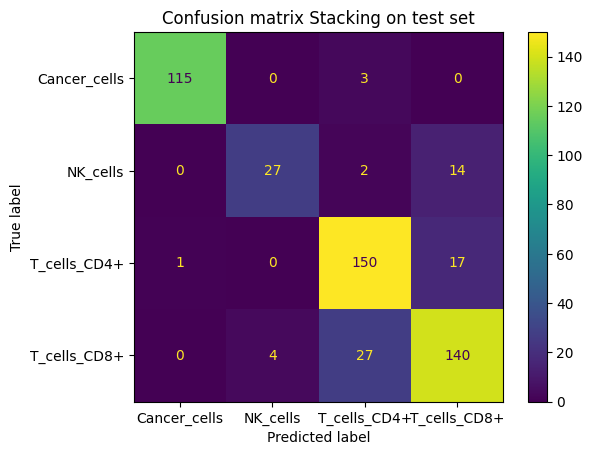

In [37]:
# Define base models
base_models = [
    #('pca_svc', make_pipeline( PCA(n_components=50), SVC(kernel='linear', C=1.0))),
    ('rf', make_pipeline(PCA(n_components=85), RandomForestClassifier(n_estimators=50,max_features=3))),
    #('knn', make_pipeline(TruncatedSVD(n_components=20),KNeighborsClassifier(n_neighbors=5))),
    ('mlp', make_pipeline(StandardScaler(with_mean=False), PCA(n_components=50), MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=1000))),
]

# Define the meta-model
meta_model = MLPClassifier(hidden_layer_sizes=(64, 64), activation='relu', solver='adam', max_iter=1000)

# Create the stacking classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Define the overall pipeline
pipeline = Pipeline([
    ('preprocess', StandardScaler(with_mean=False)),  # You can add any preprocessing steps here
    ('stacking', stacking_clf)
])

# Train the pipeline
X_train_selected_norm = preprocess_X(X_train_selected)
X_test_selected_norm = preprocess_X(X_test_selected)
pipeline.fit(X_train_selected_norm, y_train)

# Predict on the test set
y_te_pred_stacking = pipeline.predict(X_test_selected_norm)

# Compute balanced accuracy and confusion matrix for the stacking model
print(f"Stacking model balanced accuracy on test set: {balanced_accuracy_score(y_test, y_te_pred_stacking):.3f}")
cm_stacking = confusion_matrix(y_test, y_te_pred_stacking)
disp_stacking = ConfusionMatrixDisplay(confusion_matrix=cm_stacking, display_labels=np.unique(y_test))
disp_stacking.plot()
plt.title("Confusion matrix Stacking on test set")
plt.show()

In [38]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint
from sklearn.metrics import make_scorer, recall_score, accuracy_score
from sklearn.decomposition import PCA

Stacking model balanced accuracy on test set: 0.821


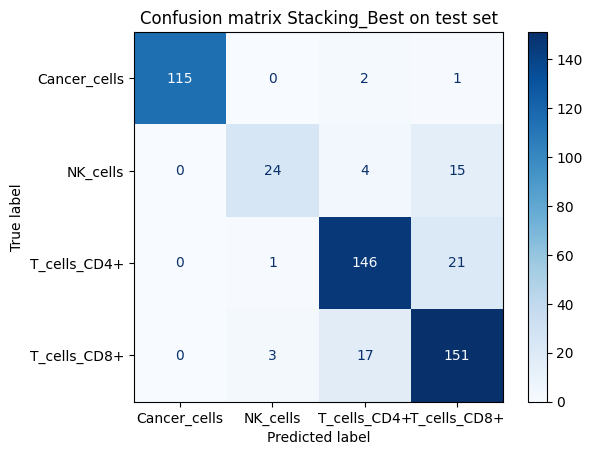

In [39]:
"""
# Define base models
base_models = [
    #('pca_svc', make_pipeline(SelectFromModel(Lasso(alpha=0.05)), SVC(kernel='linear', C=1.0))), ##100##12 PCA(n_components=50),
    ('rf', make_pipeline(StandardScaler(), SelectFromModel(Lasso(alpha=0.06283860093330873)), RandomForestClassifier(random_state=42, n_estimators= 96, max_features=15))),  ##50##3 PCA(n_components=50),
    #('mlp', make_pipeline(StandardScaler(with_mean=False), SelectFromModel(Lasso(alpha=0.06283860093330873)), MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=1000))),  ## PCA(n_components=40),
    ('mlp', make_pipeline(StandardScaler(), SelectFromModel(RandomForestClassifier(n_estimators=74, max_features=13, random_state=42)), MLPClassifier( hidden_layer_sizes=(256, 256), activation='relu', solver='adam', max_iter=865))),
    #('mlp', make_pipeline(StandardScaler(), SelectFromModel(Lasso(alpha=0.06283860093330873)),MLPClassifier(random_state=42, hidden_layer_sizes=(64, 64), activation='relu', solver='adam', max_iter=899))),
        ]
# Define the meta-model
meta_model = MLPClassifier(hidden_layer_sizes=(64, 64), activation='relu', solver='adam', max_iter=1187)

base_models = [
    #('pca_svc', make_pipeline(SelectFromModel(Lasso(alpha=0.05)), SVC(kernel='linear', C=1.0))), ##100##12 PCA(n_components=50),
   # ('rf', make_pipeline(StandardScaler(), SelectFromModel(Lasso(alpha=0.06283860093330873)), RandomForestClassifier(random_state=42, n_estimators= 96, max_features=15))),  ##50##3 PCA(n_components=50),
    ('rf', make_pipeline(StandardScaler(), SelectFromModel(Lasso(alpha=0.04165852851773962)), RandomForestClassifier(random_state=42, n_estimators= 72, max_features=19))),  ##50##3 PCA(n_components=50),
    #('mlp', make_pipeline(StandardScaler(with_mean=False), SelectFromModel(Lasso(alpha=0.06283860093330873)), MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=1000))),  ## PCA(n_components=40),
    ('mlp', make_pipeline(StandardScaler(), SelectFromModel(RandomForestClassifier(n_estimators=62, max_features=13, random_state=42)), MLPClassifier( hidden_layer_sizes=(512, 256), activation='relu', solver='adam', max_iter=1264))),
    #('mlp', make_pipeline(StandardScaler(), SelectFromModel(Lasso(alpha=0.06283860093330873)),MLPClassifier(random_state=42, hidden_layer_sizes=(64, 64), activation='relu', solver='adam', max_iter=899))),
        ]
        
# Define the meta-model
meta_model = MLPClassifier(hidden_layer_sizes=(256, 128), activation='relu', solver='adam', max_iter=989)
"""
base_models = [
            #('pca_svc', make_pipeline(SelectFromModel(Lasso(alpha=0.05)), SVC(kernel='linear', C=1.0))), ##100##12 PCA(n_components=50),
           # ('rf', make_pipeline(StandardScaler(), SelectFromModel(Lasso(alpha=0.06283860093330873)), RandomForestClassifier(random_state=42, n_estimators= 96, max_features=15))),  ##50##3 PCA(n_components=50),
            ('rf', make_pipeline(StandardScaler(), SelectFromModel(Lasso(alpha=0.04165852851773962)), RandomForestClassifier(random_state=42, n_estimators= 72, max_features=19))),  ##50##3 PCA(n_components=50),
            #('mlp', make_pipeline(StandardScaler(with_mean=False), SelectFromModel(Lasso(alpha=0.06283860093330873)), MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=1000))),  ## PCA(n_components=40),
            ('mlp', make_pipeline(StandardScaler(), SelectFromModel(RandomForestClassifier(n_estimators=74, max_features=13, random_state=42)), MLPClassifier( hidden_layer_sizes=(512, 256), activation='relu', solver='adam', max_iter=865))),
            #('mlp', make_pipeline(StandardScaler(), SelectFromModel(Lasso(alpha=0.06283860093330873)),MLPClassifier(random_state=42, hidden_layer_sizes=(64, 64), activation='relu', solver='adam', max_iter=899))),
        ]
# Define the meta-model
meta_model = MLPClassifier(hidden_layer_sizes=(256, 128), activation='relu', solver='adam', max_iter=1187)


# Create the stacking classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Define the overall pipeline
pipeline = Pipeline([
    ('preprocess', StandardScaler(with_mean=False)),  # You can add any preprocessing steps here
    ('stacking', stacking_clf)
])

# Train the pipeline
X_train_norm = preprocess_X(X_train)
X_test_norm = preprocess_X(X_test)
pipeline.fit(X_train_norm, y_train)

# Predict on the test set
y_te_pred_stacking = pipeline.predict(X_test_norm)

# Compute balanced accuracy and confusion matrix for the stacking model
print(f"Stacking model balanced accuracy on test set: {balanced_accuracy_score(y_test, y_te_pred_stacking):.3f}")
cm_stacking = confusion_matrix(y_test, y_te_pred_stacking)
disp_stacking = ConfusionMatrixDisplay(confusion_matrix=cm_stacking, display_labels=np.unique(y_test))
disp_stacking.plot(cmap="Blues")
plt.title("Confusion matrix Stacking_Best on test set")
plt.show()


In [40]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

print('Train accuracy:', accuracy_score(y_train, pipeline.predict(X_train_norm)))
print('Test accuracy:', accuracy_score(y_test, y_te_pred_stacking))

print('Train recall:', recall_score(y_train, pipeline.predict(X_train_norm), average='weighted'))
print('Test recall:', recall_score(y_test, y_te_pred_stacking, average='weighted'))

print('Train precision:', precision_score(y_train, pipeline.predict(X_train_norm), average='weighted'))
print('Test precision:', precision_score(y_test, y_te_pred_stacking, average='weighted'))


print('Train f1:', f1_score(y_train, pipeline.predict(X_train_norm), average='weighted'))
print('Test f1:', f1_score(y_test, y_te_pred_stacking, average='weighted'))


Train accuracy: 1.0
Test accuracy: 0.872
Train recall: 1.0
Test recall: 0.872
Train precision: 1.0
Test precision: 0.8746779644251002
Train f1: 1.0
Test f1: 0.8699349139636543


In [120]:
#ce code a permis d'optimiser les parametres de RF pour obtenir 86% d'accuracy

# Définir les hyperparamètres à optimiser pour le pipeline
param_dist = {
    'selectfrommodel__estimator__alpha': uniform(0.001, 0.7),  # Alpha pour Lasso
    'randomforestclassifier__n_estimators': randint(50, 100),  # Nombre d'estimateurs pour RandomForest
    'randomforestclassifier__max_features': randint(1,20)  # Max_features pour RandomForest
}
# Définir la fonction de score personnalisée pour l'accuracy
accuracy_scorer = make_scorer(accuracy_score)
# Création du pipeline pour RandomForestClassifier avec Lasso pour la sélection des caractéristiques
rf_pipeline = make_pipeline(
    SelectFromModel(Lasso(alpha=0.01)),
    RandomForestClassifier(random_state=4)
)
# Utiliser RandomizedSearchCV pour l'optimisation avec l'accuracy comme métrique
random_search = RandomizedSearchCV(rf_pipeline, param_distributions=param_dist, n_iter=50, cv=5, scoring=accuracy_scorer, random_state=42, error_score='raise')
random_search.fit(X_train, y_train_encoded)  # Remplacez par vos données d'entraînement

# Afficher les meilleurs paramètres
print("Meilleurs paramètres:", random_search.best_params_)
#Meilleurs paramètres: {'randomforestclassifier__max_features': 8, 'randomforestclassifier__n_estimators': 70, 'selectfrommodel__estimator__alpha': 0.11021304830970556}
###Meilleurs paramètres: {'randomforestclassifier__max_features': 19, 'randomforestclassifier__n_estimators': 72, 'selectfrommodel__estimator__alpha': 0.04165852851773962}
##Meilleurs paramètres: {'randomforestclassifier__max_features': 130, 'randomforestclassifier__n_estimators': 163, 'selectfrommodel__estimator__alpha': 0.001}
#Meilleurs paramètres: {'randomforestclassifier__max_features': 15, 'randomforestclassifier__n_estimators': 96, 'selectfrommodel__estimator__alpha': 0.06283860093330873}

C:\Users\astri\anaconda3\envs\data-camp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.28104662895202637, tolerance: 0.10627187043428421
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\astri\anaconda3\envs\data-camp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7418514490127563, tolerance: 0.10627187043428421
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\astri\anaconda3\envs\data-camp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6266041994094849, tolerance: 0.10610197484493256
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\astri\anaconda3\envs\dat

Meilleurs paramètres: {'randomforestclassifier__max_features': 8, 'randomforestclassifier__n_estimators': 70, 'selectfrommodel__estimator__alpha': 0.11021304830970556}


In [23]:
# Espace de paramètres pour MLP sans Lasso
mlp_param_dist_ = {
    'mlpclassifier__hidden_layer_sizes': [(64, 64), (128, 64), (128, 128), (256, 128), (512, 256), (256, 256), (64, 128)],
    #'mlpclassifier__activation': ['tanh', 'relu'],
    #'mlpclassifier__solver': ['sgd', 'adam'],
    'mlpclassifier__max_iter': randint(500, 1400)
    #'selectfrommodel__estimator__alpha': uniform(0.001, 0.1)
}
accuracy_scorer = make_scorer(accuracy_score)
# Création du pipeline pour MLP avec Lasso pour la sélection des caractéristiques
mlp_pipeline_ = make_pipeline(MLPClassifier())
# Utiliser RandomizedSearchCV pour l'optimisation avec l'accuracy comme métrique
random_search = RandomizedSearchCV(mlp_pipeline_, param_distributions=mlp_param_dist_, n_iter=25, cv=5, scoring="accuracy", error_score='raise')
random_search.fit(X_train, y_train_encoded)  # Remplacez par vos données d'entraînement

# Afficher les meilleurs paramètres
print("Meilleurs paramètres:", random_search.best_params_)
#Meilleurs paramètres: {'mlpclassifier__hidden_layer_sizes': (256, 128), 'mlpclassifier__max_iter': 828}
##Meilleurs paramètres: {'mlpclassifier__activation': 'tanh', 'mlpclassifier__hidden_layer_sizes': (64, 64), 'mlpclassifier__max_iter': 899, 'mlpclassifier__solver': 'adam'}
#Meilleurs paramètres: {'mlpclassifier__activation': 'relu', 'mlpclassifier__hidden_layer_sizes': (128, 128), 'mlpclassifier__max_iter': 989, 'mlpclassifier__solver': 'adam'}

Meilleurs paramètres: {'mlpclassifier__hidden_layer_sizes': (512, 256), 'mlpclassifier__max_iter': 794}


In [43]:
# Espace de paramètres pour MLP sans Lasso
mlp_param_dist_ = {
    'mlpclassifier__hidden_layer_sizes': [(64, 64), (128, 64), (128, 128), (256, 128), (512, 256), (256, 256), (64, 128)],
    #'mlpclassifier__activation': ['tanh', 'relu'],
    #'mlpclassifier__solver': ['sgd', 'adam'],
    'mlpclassifier__max_iter': randint(500, 1400),
    'selectfrommodel__estimator__alpha': uniform(0.001, 0.7)
}
accuracy_scorer = make_scorer(accuracy_score)
# Création du pipeline pour MLP avec Lasso pour la sélection des caractéristiques
mlp_pipeline_ = make_pipeline(
    SelectFromModel(Lasso(alpha=0.01)),
    MLPClassifier())
# Utiliser RandomizedSearchCV pour l'optimisation avec l'accuracy comme métrique
random_search = RandomizedSearchCV(mlp_pipeline_, param_distributions=mlp_param_dist_, n_iter=50, cv=5, scoring="accuracy", error_score='raise')
random_search.fit(X_train, y_train_encoded)  # Remplacez par vos données d'entraînement

# Afficher les meilleurs paramètres
print("Meilleurs paramètres:", random_search.best_params_)
#Meilleurs paramètres: {'mlpclassifier__hidden_layer_sizes': (512, 256), 'mlpclassifier__max_iter': 545, 'selectfrommodel__estimator__alpha': 0.16899652074171115}

C:\Users\astri\anaconda3\envs\data-camp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81.57383728027344, tolerance: 0.10641550272703171
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\astri\anaconda3\envs\data-camp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85.49891662597656, tolerance: 0.10627187043428421
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\astri\anaconda3\envs\data-camp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81.99304962158203, tolerance: 0.10627187043428421
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\astri\anaconda3\envs\data-ca

Meilleurs paramètres: {'mlpclassifier__hidden_layer_sizes': (512, 256), 'mlpclassifier__max_iter': 545, 'selectfrommodel__estimator__alpha': 0.16899652074171115}


In [121]:
from sklearn.feature_selection import SelectFromModel
# Espace de paramètres pour MLP sans Lasso
mlp_param_dist_ = {
    'selectfrommodel__estimator__n_estimators': randint(30, 120),
    'selectfrommodel__estimator__max_features': randint(1, 30),
    'mlpclassifier__hidden_layer_sizes': [(128, 64), (128, 128), (256, 128), (512, 256), (256, 256), (64, 128), (64, 64) ],
    #'mlpclassifier__activation': ['tanh', 'relu'],
    #'mlpclassifier__solver': ['sgd', 'adam'],
    'mlpclassifier__max_iter': randint(700, 1300)
}

accuracy_scorer = make_scorer(accuracy_score)
# Création du pipeline pour MLP avec Lasso pour la sélection des caractéristiques
mlp_pipeline_ = make_pipeline(
    SelectFromModel(estimator=RandomForestClassifier(random_state=4)),
    MLPClassifier()
)
# Utiliser RandomizedSearchCV pour l'optimisation avec l'accuracy comme métrique
random_search = RandomizedSearchCV(mlp_pipeline_, param_distributions=mlp_param_dist_, n_iter=25, cv=5, scoring=accuracy_scorer, error_score='raise')
random_search.fit(X_train, y_train_encoded)  # Remplacez par vos données d'entraînement

# Afficher les meilleurs paramètres
print("Meilleurs paramètres:", random_search.best_params_)
#Meilleurs paramètres: {'mlpclassifier__hidden_layer_sizes': (512, 256), 'mlpclassifier__max_iter': 839, 'selectfrommodel__estimator__max_features': 27, 'selectfrommodel__estimator__n_estimators': 58}
####Meilleurs paramètres: {'mlpclassifier__hidden_layer_sizes': (512, 256), 'mlpclassifier__max_iter': 1264, 'selectfrommodel__estimator__max_features': 13, 'selectfrommodel__estimator__n_estimators': 62}
###Meilleurs paramètres: {'mlpclassifier__hidden_layer_sizes': (256, 128), 'mlpclassifier__max_iter': 865, 'selectfrommodel__estimator__max_features': 13, 'selectfrommodel__estimator__n_estimators': 74}
##Meilleurs paramètres: {'mlpclassifier__activation': 'tanh', 'mlpclassifier__hidden_layer_sizes': (64, 64), 'mlpclassifier__max_iter': 899, 'mlpclassifier__solver': 'adam'}
#Meilleurs paramètres: {'mlpclassifier__activation': 'relu', 'mlpclassifier__hidden_layer_sizes': (128, 128), 'mlpclassifier__max_iter': 989, 'mlpclassifier__solver': 'adam'}


Meilleurs paramètres: {'mlpclassifier__hidden_layer_sizes': (512, 256), 'mlpclassifier__max_iter': 839, 'selectfrommodel__estimator__max_features': 27, 'selectfrommodel__estimator__n_estimators': 58}


In [ ]:
pip install scikit-optimize

In [ ]:
param_space = {
    'selectfrommodel__estimator__alpha': (0.01, 1.0, 'log-uniform'),
    'randomforestclassifier__n_estimators': randint(100, 200),  # Utilisez 'uniform' pour une distribution uniforme
    'randomforestclassifier__max_depth': (1, 20),
    'randomforestclassifier__min_samples_split': (0.1, 1.0),
    'randomforestclassifier__min_samples_leaf': (0.1, 0.5, 'uniform'),
}

# Utiliser BayesSearchCV pour l'optimisation avec l'accuracy comme métrique
rf_pipeline = make_pipeline(
    SelectFromModel(Lasso(alpha=0.01)),
    RandomForestClassifier(random_state=4)
)
accuracy_scorer = make_scorer(accuracy_score)
Bayes_search = BayesSearchCV(rf_pipeline, search_spaces=param_dist, n_iter=10, cv=3, scoring=accuracy_scorer, random_state=42)
Bayes_search.fit(X_train, y_train)  # Remplacez par vos données d'entraînement

# Afficher les meilleurs paramètres
print("Meilleurs paramètres:", Bayes_search.best_params_)

In [ ]:
from skopt import BayesSearchCV

param_space = {
    'selectfrommodel__estimator__alpha': (0.01, 1.0, 'log-uniform'),
    'randomforestclassifier__n_estimators': randint(100, 200),  # Utilisez 'uniform' pour une distribution uniforme
    'randomforestclassifier__max_depth': (1, 20),
    'randomforestclassifier__min_samples_split': (0.1, 1.0),
    'randomforestclassifier__min_samples_leaf': (0.1, 0.5, 'uniform'),
}

# Utiliser BayesSearchCV pour l'optimisation avec l'accuracy comme métrique
rf_pipeline = make_pipeline(
    SelectFromModel(Lasso(alpha=0.01)),
    RandomForestClassifier(random_state=4)
)
accuracy_scorer = make_scorer(accuracy_score)
Bayes_search = BayesSearchCV(rf_pipeline, search_spaces=param_dist, n_iter=10, cv=3, scoring=accuracy_scorer, random_state=42)
Bayes_search.fit(X_train, y_train)  # Remplacez par vos données d'entraînement

# Afficher les meilleurs paramètres
print("Meilleurs paramètres:", Bayes_search.best_params_)